In [ ]:
!pip install wfdb

     |████████████████████████████████| 122kB 6.6MB/s 


In [ ]:
import os
import wfdb
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [ ]:
# Utility functions
def normalize(arr):
    amax, amin = arr.max(), arr.min()
    return 2 * (arr - amin) / (amax - amin) - 1, amax, amin


def denormalize(yarr, ymax, ymin):
    return (yarr + 1) * (ymax - ymin) / 2 + ymin


# Create sliding window samples
def sliding_samples(arr, window_size):
    xsamples = []
    half_size = int(window_size / 2)
    # print(half_size)
    larr = len(arr)
    for i in range(larr):
        padded_array = np.zeros(window_size)
        # szer = np.zeros(window_size)
        # ssl = arr[i:i+window_size]
        d = i-half_size
        if d <= 0:
            # print(np.zeros(half_size-i))
            ssl = arr[0:i+half_size+1]
            padded_array[half_size-i:half_size-i+np.shape(ssl)[0]] = ssl
        else:
            ssl = arr[i-half_size:i+half_size+1]
            # ssl = arr[i-half_size:i+half_size]
            padded_array[:np.shape(ssl)[0]] = ssl
        xsamples.append(padded_array)
    return np.reshape(xsamples,(larr, window_size))

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

In [ ]:
# Download dataset
db_path = os.path.join(os.getcwd(), 'mitdb')
if not os.path.exists(db_path):
    wfdb.dl_database('mitdb', db_path)

Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating record list for: 103
Generating record list for: 104
Generating record list for: 105
Generating record list for: 106
Generating record list for: 107
Generating record list for: 108
Generating record list for: 109
Generating record list for: 111
Generating record list for: 112
Generating record list for: 113
Generating record list for: 114
Generating record list for: 115
Generating record list for: 116
Generating record list for: 117
Generating record list for: 118
Generating record list for: 119
Generating record list for: 121
Generating record list for: 122
Generating record list for: 123
Generating record list for: 124
Generating record list for: 200
Generating record list for: 201
Generating record list for: 202
Generating record list for: 203
Generating record list for: 205
Generating record list for: 207
Generating record list for: 208
Generating record list for: 209
Generati

In [ ]:
# Download noise dataset
db_path = os.path.join(os.getcwd(), 'nstdb')
if not os.path.exists(db_path):
    wfdb.dl_database('nstdb', db_path)

Generating record list for: 118e00
Generating record list for: 118e06
Generating record list for: 118e12
Generating record list for: 118e18
Generating record list for: 118e24
Generating record list for: 118e_6
Generating record list for: 119e00
Generating record list for: 119e06
Generating record list for: 119e12
Generating record list for: 119e18
Generating record list for: 119e24
Generating record list for: 119e_6
Generating record list for: bw
Generating record list for: em
Generating record list for: ma
Generating list of all files for: 118e00
Generating list of all files for: 118e06
Generating list of all files for: 118e12
Generating list of all files for: 118e18
Generating list of all files for: 118e24
Generating list of all files for: 118e_6
Generating list of all files for: 119e00
Generating list of all files for: 119e06
Generating list of all files for: 119e12
Generating list of all files for: 119e18
Generating list of all files for: 119e24
Generating list of all files for: 11

In [ ]:
# Parameters
sampling_frequency = 360
powerline_frequency = 60
sample_file = 'mitdb/220'
bw_noise_file = 'nstdb/bw'
em_noise_file = 'nstdb/em'
ma_noise_file = 'nstdb/ma'
window_size = 65  # Must always be odd
noise_scale_factor = 1/16
train_size, test_size, validation_size = 9000, 6000, 3000
total_sample_size = train_size + test_size + validation_size

In [ ]:
# Get the first channel from the recording
record = wfdb.rdrecord(sample_file, channels=[0], sampto=total_sample_size)
white_noise = np.random.normal(0, 1, total_sample_size) * noise_scale_factor
powerline_space = np.linspace(0, total_sample_size * powerline_frequency / sampling_frequency * 2*np.pi, total_sample_size) 
powerline_noise = np.cos(powerline_space) *.5
bw_noise = wfdb.rdrecord(bw_noise_file, channels=[0], sampto=total_sample_size)
bw_noise = bw_noise.p_signal[:,0]
em_noise = wfdb.rdrecord(em_noise_file, channels=[0], sampto=total_sample_size)
em_noise = em_noise.p_signal[:,0]
ma_noise = wfdb.rdrecord(ma_noise_file, channels=[0], sampto=total_sample_size)
ma_noise = ma_noise.p_signal[:,0]
ecg = record.p_signal[:,0]

In [ ]:
print(np.shape(bw_noise), np.shape(ecg))

(18000,) (18000,)


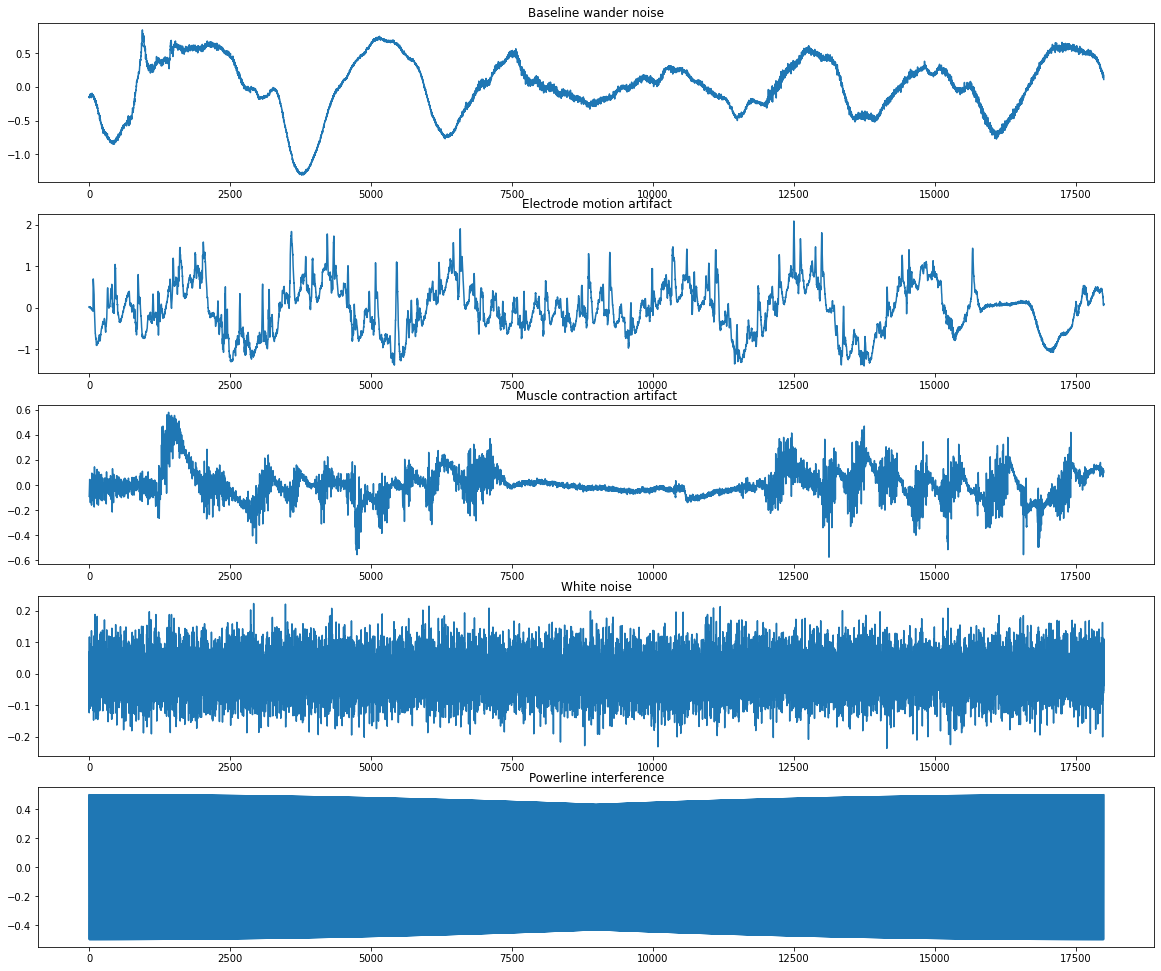

In [ ]:
fig, axs = plt.subplots(5, figsize=(20,17))
axs[0].plot(bw_noise)
axs[1].plot(em_noise)
axs[2].plot(ma_noise)
axs[3].plot(white_noise)
axs[4].plot(powerline_noise)

axs[0].set_title('Baseline wander noise')
axs[1].set_title('Electrode motion artifact')
axs[2].set_title('Muscle contraction artifact')
axs[3].set_title('White noise')
axs[4].set_title('Powerline interference')

plt.show()
fig.savefig('noise_types.png')

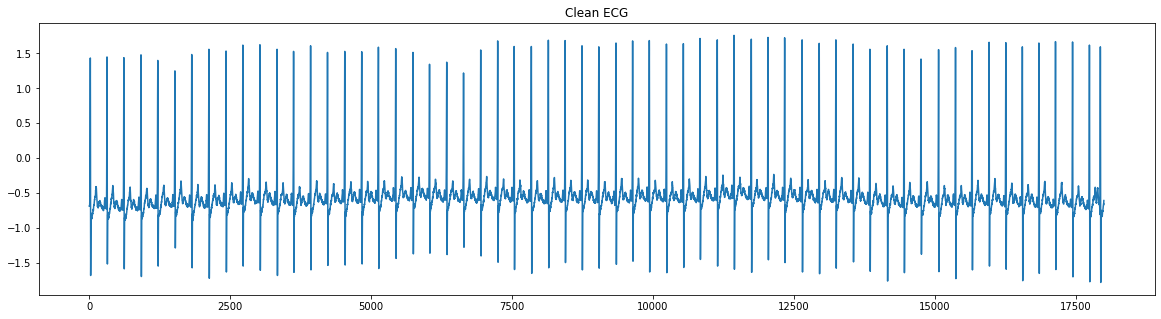

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(ecg)
plt.title('Clean ECG')
plt.show()


In [ ]:
# ecg_noisy = ecg + bw_noise + em_noise + ma_noise + white_noise
ecg_noisy = ecg + bw_noise + ma_noise + white_noise + powerline_noise + em_noise

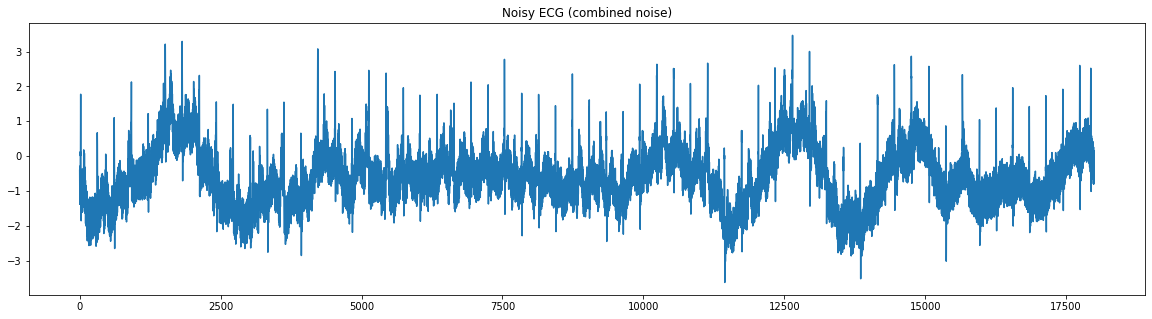

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(ecg_noisy)
plt.title('Noisy ECG (combined noise)')
plt.show()

In [ ]:
# Normalize noisy ecg signal and clean ecg signal
y, ymax, ymin = normalize(ecg)
x, xmax, xmin = normalize(ecg_noisy)

In [ ]:
# Splitting data into train, test and validation

x_train = sliding_samples(x[0:train_size], window_size)
x_test = sliding_samples(x[train_size:test_size + train_size], window_size)
x_validation = sliding_samples(x[test_size + train_size:], window_size)

y_train = np.reshape(y[0:train_size], (train_size, 1))
y_test = np.reshape(y[train_size:test_size + train_size], (test_size, 1))
y_validation = np.reshape(y[test_size + train_size:], (validation_size, 1))
np.shape(x_train), np.shape(x_test), np.shape(x_validation), np.shape(y_train), np.shape(y_test), np.shape(y_validation)

((9000, 65), (6000, 65), (3000, 65), (9000, 1), (6000, 1), (3000, 1))

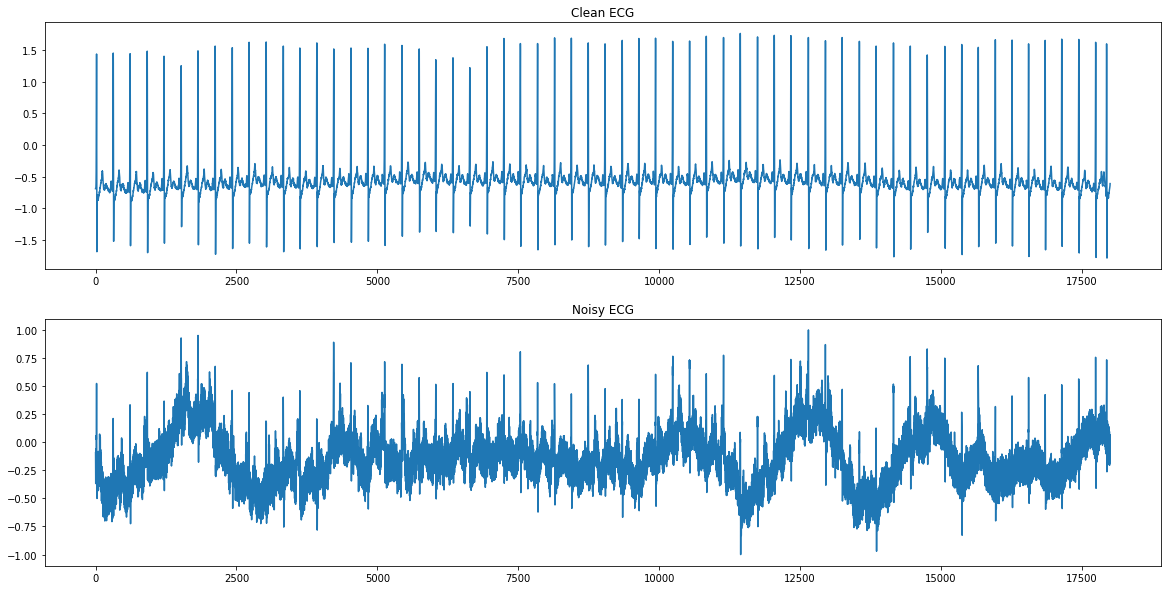

In [ ]:
# Plotting normalized ecg signal with noise
fig, axs = plt.subplots(2, figsize=(20,10))
axs[0].plot(ecg)
axs[1].plot(x)
axs[0].set_title('Clean ECG')
axs[1].set_title('Noisy ECG')
plt.show()

In [ ]:
# Creating ann model
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(window_size),
    tf.keras.layers.Dense(56, activation='tanh'),
    tf.keras.layers.Dense(12, activation='tanh'),
    tf.keras.layers.Dense(1, activation='tanh')         
])

In [ ]:
model.compile(optimizer='adam',
              loss="mse",
              metrics=['mse'])

In [ ]:
history = model.fit(x_train, y_train, epochs=40, verbose=1, validation_data=(x_test, y_test))
# list all data in history
print(history.history.keys())


Epoch 1/40
282/282 [==============================] - 2s 3ms/step - loss: 0.0358 - mse: 0.0358 - val_loss: 0.0119 - val_mse: 0.0119
Epoch 2/40
282/282 [==============================] - 1s 2ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 3/40
282/282 [==============================] - 1s 2ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 4/40
282/282 [==============================] - 1s 2ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0083 - val_mse: 0.0083
Epoch 5/40
282/282 [==============================] - 1s 2ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 6/40
282/282 [==============================] - 1s 2ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 7/40
282/282 [==============================] - 1s 2ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 8/40
282/282 [==============================] - 1s 2ms/step - loss: 0.

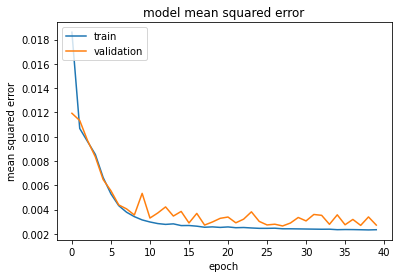

In [ ]:
# summarize history for accuracy
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mean squared error')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('model_loss.png', bbox_inches='tight')
plt.show()


In [ ]:
results = model.evaluate(x_validation, y_validation, batch_size=128)


24/24 [==============================] - 0s 1ms/step - loss: 0.0031 - mse: 0.0031


In [ ]:
predictions = model.predict(x_validation)


24/24 [==============================] - 0s 1ms/step - loss: 0.0031 - mse: 0.0031


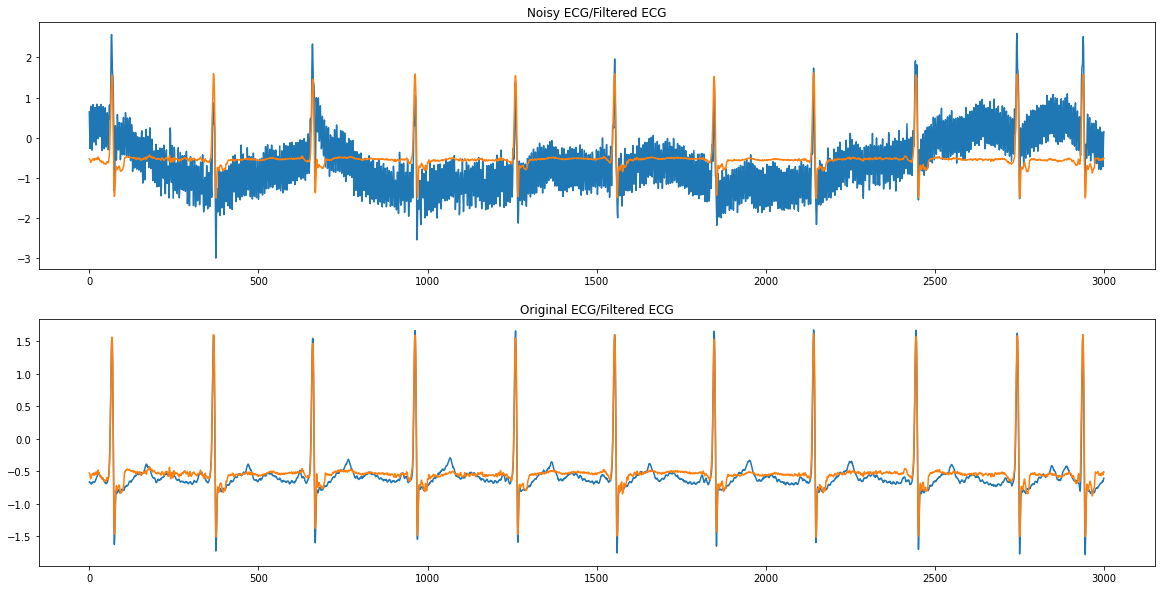

In [ ]:
def plot1(noisy, prediction, cleans):
    fig, axs = plt.subplots(2, figsize=(20,10))
    axs[0].plot(noisy)
    axs[0].plot(prediction)
    axs[1].plot(cleans)
    axs[1].plot(prediction)

    axs[0].set_title('Noisy ECG/Filtered ECG')
    axs[1].set_title('Original ECG/Filtered ECG')
    plt.show()
    fig.savefig('validation_results.png',  bbox_inches='tight')
predictions2 = denormalize(model.predict(x_validation)[:,0], ymax, ymin)
results2 = model.evaluate(x_validation, y_validation, batch_size=128)
plot1(ecg_noisy[test_size + train_size:], predictions2, ecg[train_size+test_size:])

In [ ]:
ecg_noisy_without_em = ecg + bw_noise + ma_noise + white_noise + powerline_noise

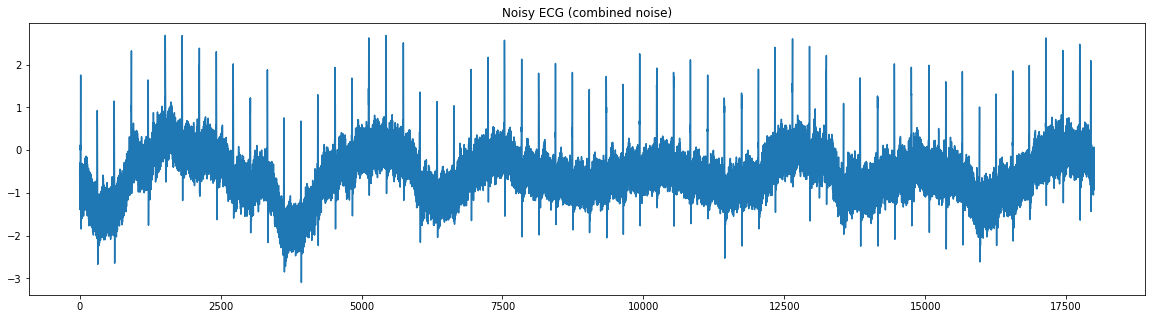

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(ecg_noisy_without_em)
plt.title('Noisy ECG (combined noise)')
plt.show()

In [ ]:
x, xmax, xmin = normalize(ecg_noisy_without_em)

In [ ]:
# Splitting data into train, test and validation

x_train = sliding_samples(x[0:train_size], window_size)
x_test = sliding_samples(x[train_size:test_size + train_size], window_size)
x_validation = sliding_samples(x[test_size + train_size:], window_size)

y_train = np.reshape(y[0:train_size], (train_size, 1))
y_test = np.reshape(y[train_size:test_size + train_size], (test_size, 1))
y_validation = np.reshape(y[test_size + train_size:], (validation_size, 1))
np.shape(x_train), np.shape(x_test), np.shape(x_validation), np.shape(y_train), np.shape(y_test), np.shape(y_validation)

((9000, 65), (6000, 65), (3000, 65), (9000, 1), (6000, 1), (3000, 1))

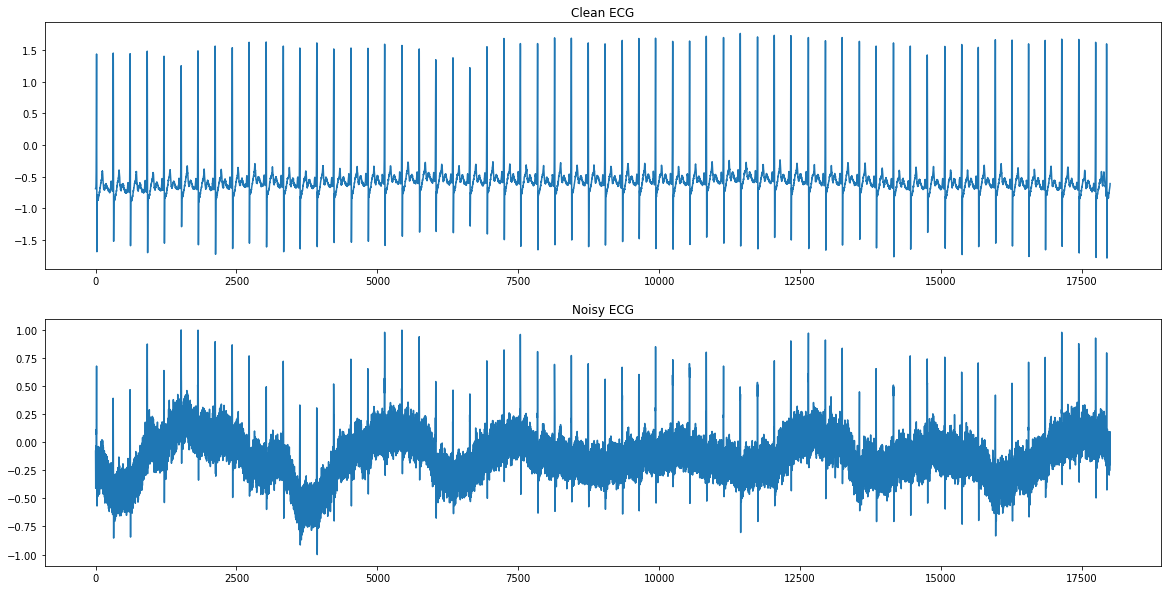

In [ ]:
# Plotting normalized ecg signal with noise
fig, axs = plt.subplots(2, figsize=(20,10))
axs[0].plot(ecg)
axs[1].plot(x)
axs[0].set_title('Clean ECG')
axs[1].set_title('Noisy ECG')
plt.show()

In [ ]:
# Creating ann model
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Input(window_size),
    tf.keras.layers.Dense(56, activation='tanh'),
    tf.keras.layers.Dense(12, activation='tanh'),
    tf.keras.layers.Dense(1, activation='tanh')         
])

In [ ]:
model2.compile(optimizer='adam',
              loss="mse",
              metrics=['mse'])

In [ ]:
history2 = model2.fit(x_train, y_train, epochs=40, verbose=1, validation_data=(x_test, y_test))
# list all data in history
print(history2.history.keys())

Epoch 1/40
282/282 [==============================] - 1s 2ms/step - loss: 0.0454 - mse: 0.0454 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 2/40
282/282 [==============================] - 1s 2ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 3/40
282/282 [==============================] - 1s 2ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 4/40
282/282 [==============================] - 1s 2ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 5/40
282/282 [==============================] - 1s 2ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 6/40
282/282 [==============================] - 1s 2ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 7/40
282/282 [==============================] - 1s 2ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 8/40
282/282 [==============================] - 1s 2ms/step - loss: 0.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


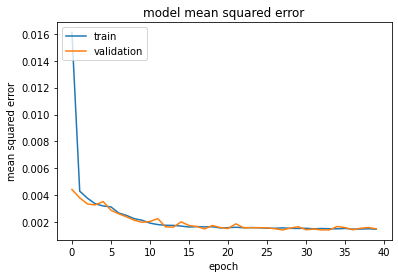

In [ ]:
# summarize history for accuracy
plt.plot(history2.history['mse'])
plt.plot(history2.history['val_mse'])
plt.title('model mean squared error')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('model_loss1.ps', bbox_inches='tight')
plt.show()

In [ ]:
results = model2.evaluate(x_validation, y_validation, batch_size=128)


24/24 [==============================] - 0s 1ms/step - loss: 0.0016 - mse: 0.0016


In [ ]:
predictions = model2.predict(x_validation)


24/24 [==============================] - 0s 1ms/step - loss: 0.0016 - mse: 0.0016


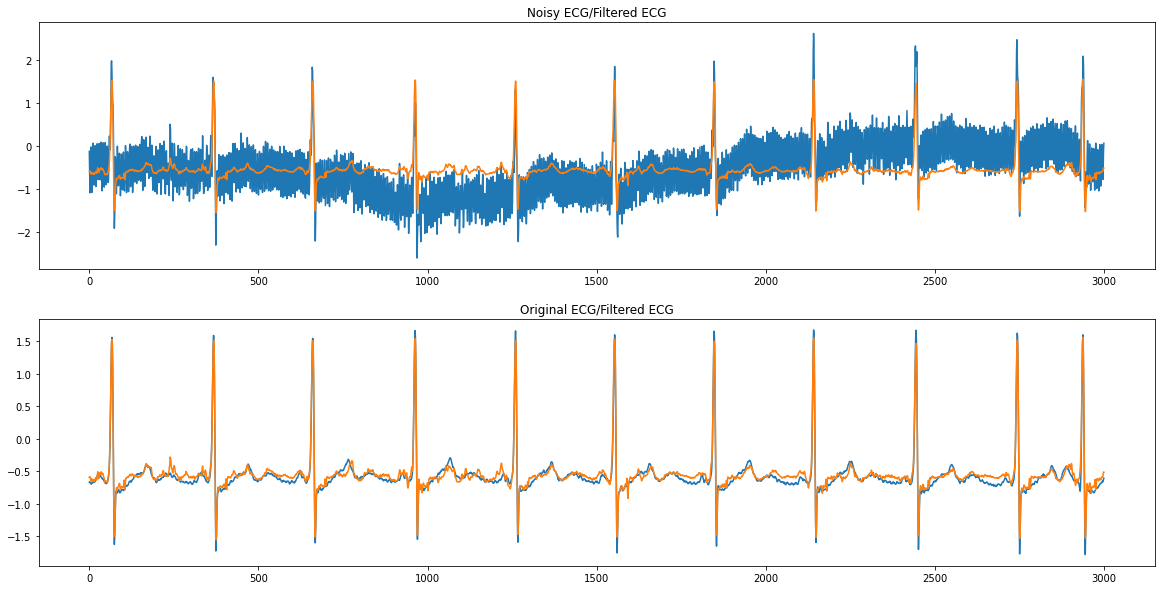

In [ ]:
predictions2 = denormalize(model2.predict(x_validation)[:,0], ymax, ymin)
results2 = model2.evaluate(x_validation, y_validation, batch_size=128)
plot1(ecg_noisy_without_em[test_size + train_size:], predictions2, ecg[train_size+test_size:])